In [1]:
# Import numpy, time, matplotlib, Keras models, backend, layers and utils
# set random seed using random.seed from numpy

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# Import cifar10 from keras datasets
# Load CIFAR10 dataset from Keras datasets module seperately as train and test datasets
# Obtain number of training and testing examples, image dimensions and number of classes

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

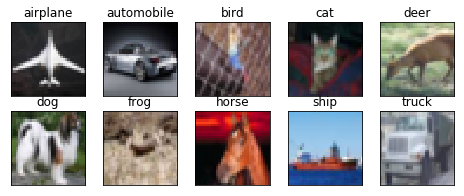

In [3]:
# Display images corresponding to each class from training dataset

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Define function to plot summarize history for accuracy and loss


def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Define function to calculate accuracy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Convert the Tensor i.e. train and test dataset to float tensors. Also perform a min-max normalization where min = 0 and max = 255
# # Convert 1-dimensional class arrays to num_classes-dimensional class matrices

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, SeparableConv2D, DepthwiseConv2D
from keras.models import Model

# Define the model


inputs = Input(shape=(32, 32, 3))

# 2D convolution layer (e.g. spatial convolution over images) using 3x3 Kernel
x1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
x1 = BatchNormalization()(x1) # BatchNormalization layer
x1 = Dropout(0.1)(x1)# Droput is set to 0.1


# Spacially Separable convolution
#x2 = DepthwiseConv2D((1,3), padding='same', activation='relu', depth_multiplier=1)(x1)
#x2 = DepthwiseConv2D((3,1), padding='same', activation='relu', depth_multiplier=2)(x2)
x2 = Conv2D(64, (1,3), padding='same', activation=None)(x1)
x2 = Conv2D(128, (3,1), padding='same', activation='relu')(x2)
x2 = BatchNormalization()(x2) # BatchNormalization layer
x2 = Dropout(0.1)(x2)# Droput is set to 0.1

# 2D convolution layer (e.g. spatial convolution over images) using 1x1 Kernel. This is transition block.
x3 = Conv2D(32, (1, 1), padding='same', activation='relu')(x2)
x3 = BatchNormalization()(x3) # BatchNormalization layer
x3 = Dropout(0.1)(x3)# Droput is set to 0.1


m1 = MaxPooling2D(pool_size=(2, 2))(x3) #MaxPooling layer

# Depthwise Convolution
x4 = SeparableConv2D(64, (3, 3), padding='same', activation='relu')(m1)
x4 = BatchNormalization()(x4) # BatchNormalization layer
x4 = Dropout(0.1)(x4)# Droput is set to 0.1


# Grouped Convolution (using 3x3, 5x5 only)
x5 = Conv2D(256, (3, 3), padding='same', activation='relu')(x4)
x6 = Conv2D(256, (5, 5), padding='same', activation='relu')(x4)
x7 = concatenate([x5, x6], axis = -1)
g1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x7)
g1 = BatchNormalization()(g1) # BatchNormalization layer
g1 = Dropout(0.1)(g1)# Droput is set to 0.1


# 2D convolution layer (e.g. spatial convolution over images) using 1x1 Kernel. This is transition block.
x8 = Conv2D(64, (1, 1), padding='same', activation='relu')(g1)
x8 = BatchNormalization()(x8) # BatchNormalization layer
x8 = Dropout(0.1)(x8)# Droput is set to 0.1

m2 = MaxPooling2D(pool_size=(2, 2))(x8)


# Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 
x9 = Conv2D(256, (3, 3), dilation_rate=(1, 1), padding='same', activation='relu')(m2)
x10 = Conv2D(256, (3, 3), dilation_rate=(2, 2), padding='same', activation='relu')(m2)
x11 = concatenate([x9, x10], axis = -1)
g2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x11)
g2 = BatchNormalization()(g2) # BatchNormalization layer
g2 = Dropout(0.1)(g2)# Droput is set to 0.1


x12 = Conv2D(num_classes, (8, 8))(g2)

out = Flatten()(x12) #The outputs from the previous layer are flattened
predictions = Activation('softmax')(out) #Softmax activation layer.So that the values of logits are squished between 0 and 1

model = Model(inputs=inputs, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Compiles the model i.e. specify loss, type of optimizer to use while training, metrics that needs to be calculated and displayed.
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Displays the summary of the model i.e. gives the details of different shapes and channels in different layers of the model.

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Epoch 1/50
390/390 [==============================] - 40s 102ms/step - loss: 1.5738 - acc: 0.4865 - val_loss: 2.0751 - val_acc: 0.4156
Epoch 2/50
390/390 [==============================] - 36s 92ms/step - loss: 1.0107 - acc: 0.6593 - val_loss: 0.9954 - val_acc: 0.6643
Epoch 3/50
390/390 [==============================] - 35s 91ms/step - loss: 0.7438 - acc: 0.7413 - val_loss: 0.8265 - val_acc: 0.7196
Epoch 4/50
390/390 [==============================] - 35s 91ms/step - loss: 0.6219 - acc: 0.7829 - val_loss: 0.7520 - val_acc: 0.7524
Epoch 5/50
390/390 [==============================] - 35s 91ms/step - loss: 0.5312 - acc: 0.8139 - val_loss: 0.7664 - val_acc: 0.7603
Epoch 6/50
390/390 [==============================] - 35s 91ms/step - loss: 0.4613 - acc: 0.8369 - val_loss: 0.6764 - val_acc: 0.7787
Epoch 7/50
390/390 [==============================] - 36s 91ms/step - loss: 0.3986 - acc: 0.8597 - val_loss: 0.8327 - val_acc: 0.7501
Epoch 8/50
390/390 [==============================] - 36s 91m

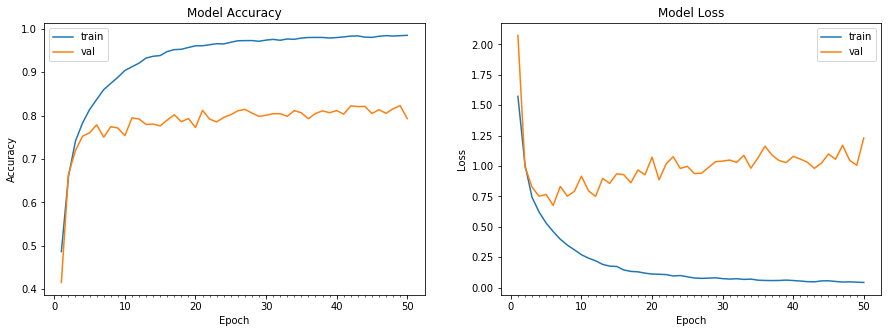

Accuracy on test data is: 79.29


In [10]:
# Train the model using fit_generator function. Also calculate and display total time taken for training. Along with this plot summarize history for accuracy and loss. Display accuracy on validation dataset.

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### **References & Attributions:**

*   Keras (https://keras.io/)

*   Tensorflow 2.1 (https://www.tensorflow.org/api_docs/python/)


*Disclaimer: The contents of this notebook are used for educational purposes i.e. for learning and research.*